# **Notebook 2b**: Sign Condition

<span style="font-size: 1.5rem;">By **Alison Attard**</span>

## Section 0: Notebook Metadata and Configuration

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.transforms.functional import to_tensor
import json
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import time
import random
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
from pycocotools.coco import COCO
from collections import defaultdict
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

In [2]:
SEED = 3129
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
COURSE = "ARI3129"
TASK = "Task 2b - Condition Classification"
STUDENT = "Alison Attard"
DETECTOR_NAME = "centernet"
ATTRIBUTE_FOCUS = "sign_condition"
FRAMEWORK = "PyTorch"

repo_root = Path.cwd()
dataset_root_annotations = repo_root / "dataset" / "COCO-based_COCO_condition"
dataset_root_images = repo_root / "dataset" / "COCO-based_COCO"
work_dir = repo_root / "work_dirs" / f"{DETECTOR_NAME}_{ATTRIBUTE_FOCUS}"

annotations_dir = dataset_root_annotations / "annotations"
train_annot = annotations_dir / "train.json"
val_annot = annotations_dir / "val.json"
test_annot = annotations_dir / "test.json"

images_dir = dataset_root_images / "images"
train_imgs = images_dir / "train"
val_imgs = images_dir / "val"
test_imgs = images_dir / "test"

checkpoint_dir = work_dir / "checkpoints"
tensorboard_dir = work_dir / "logs"
results_dir = work_dir / "results"

checkpoint_dir.mkdir(parents=True, exist_ok=True)
tensorboard_dir.mkdir(parents=True, exist_ok=True)
results_dir.mkdir(parents=True, exist_ok=True)

NUM_EPOCHS = 10
BATCH_SIZE = 8
LEARNING_RATE = 0.001
INPUT_SIZE = 512
NUM_CLASSES = 3
TIMESTAMP = datetime.now().strftime("%Y%m%d_%H%M%S")

CLASS_NAMES = [
    'Good',
    'Weathered',
    'Heavily Damaged'
]

## Section 1: Environment Setup (PyTorch + Logging)

In [4]:
print("notebook metadata and configuration")
print(f"course: {COURSE}")
print(f"task: {TASK}")
print(f"student: {STUDENT}")
print(f"detector: {DETECTOR_NAME}")
print(f"attribute: {ATTRIBUTE_FOCUS}")
print(f"framework: {FRAMEWORK}")
print(f"seed: {SEED}")
print()

print("pytorch environment")
print(f"pytorch version: {torch.__version__}")
print(f"cuda available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"gpu name: {torch.cuda.get_device_name(0)}")
    print(f"gpu memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} gb")
print()

print("model configuration")
print(f"input size: {INPUT_SIZE}")
print(f"num classes: {NUM_CLASSES}")
print(f"batch size: {BATCH_SIZE}")
print(f"epochs: {NUM_EPOCHS}")
print(f"learning rate: {LEARNING_RATE}")
print()

notebook metadata and configuration
course: ARI3129
task: Task 2b - Condition Classification
student: Alison Attard
detector: centernet
attribute: sign_condition
framework: PyTorch
seed: 3129

pytorch environment
pytorch version: 2.9.0
cuda available: False

model configuration
input size: 512
num classes: 3
batch size: 8
epochs: 10
learning rate: 0.001



In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
writer = SummaryWriter(log_dir=str(tensorboard_dir))
print(f"device: {device}")

device: cpu


## Section 2: Dataset Validation 

In [6]:
print("dataset validation")
print()

if train_annot.exists():
    print(f"train json found")
else:
    print(f"warning: train json not found at {train_annot}")

if val_annot.exists():
    print(f"val json found")
else:
    print(f"warning: val json not found at {val_annot}")

if test_annot.exists():
    print(f"test json found")
else:
    print(f"warning: test json not found at {test_annot}")

if train_imgs.exists():
    print(f"train images found")
else:
    print(f"warning: train images not found")

if val_imgs.exists():
    print(f"val images found")
else:
    print(f"warning: val images not found")

if test_imgs.exists():
    print(f"test images found")
else:
    print(f"warning: test images not found")

print()

dataset validation

train json found
val json found
test json found
train images found
val images found
test images found



### Dataset Analysis

In [7]:
print("loading and analyzing coco annotations")
print()

coco_train = COCO(str(train_annot))
coco_val = COCO(str(val_annot))
coco_test = COCO(str(test_annot))

print(f"train images: {len(coco_train.imgs)}")
print(f"train annotations: {len(coco_train.anns)}")
print(f"val images: {len(coco_val.imgs)}")
print(f"val annotations: {len(coco_val.anns)}")
print(f"test images: {len(coco_test.imgs)}")
print(f"test annotations: {len(coco_test.anns)}")
print()

train_class_counts = defaultdict(int)
val_class_counts = defaultdict(int)
test_class_counts = defaultdict(int)

for ann in coco_train.anns.values():
    train_class_counts[ann['category_id']] += 1

for ann in coco_val.anns.values():
    val_class_counts[ann['category_id']] += 1

for ann in coco_test.anns.values():
    test_class_counts[ann['category_id']] += 1

print("condition distribution in training set:")
for cat in coco_train.cats.values():
    cat_id = cat['id']
    count = train_class_counts.get(cat_id, 0)
    print(f"  {cat['name']}: {count}")
print()

print("condition distribution in validation set:")
for cat in coco_val.cats.values():
    cat_id = cat['id']
    count = val_class_counts.get(cat_id, 0)
    print(f"  {cat['name']}: {count}")
print()

print("condition distribution in test set:")
for cat in coco_test.cats.values():
    cat_id = cat['id']
    count = test_class_counts.get(cat_id, 0)
    print(f"  {cat['name']}: {count}")
print()

loading and analyzing coco annotations

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
train images: 483
train annotations: 527
val images: 88
val annotations: 92
test images: 86
test annotations: 93

condition distribution in training set:
  Good: 421
  Heavily Damaged: 13
  Weathered: 93

condition distribution in validation set:
  Good: 80
  Heavily Damaged: 1
  Weathered: 11

condition distribution in test set:
  Good: 72
  Heavily Damaged: 2
  Weathered: 19



## Section 3: Model Setup and Configuration (PyTorch)

### Custom Dataset & Data Loader

In [8]:
from PIL import Image, ImageOps
class TrafficSignConditionDataset(Dataset):
    def __init__(self, coco_annotation, images_path, input_size=512, augment=False):
        self.coco = coco_annotation
        self.images_path = Path(images_path)
        self.input_size = input_size
        self.augment = augment
        self.image_ids = list(self.coco.imgs.keys())

        self.transform_normalize = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])

        self.transform_augment = transforms.Compose([
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))
        ])

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_info = self.coco.imgs[img_id]
        img_path = self.images_path / img_info['file_name']

        image = Image.open(img_path).convert('RGB')
        

        # to avoid image rotation
        image = ImageOps.exif_transpose(image)
        original_width, original_height = image.size

        image = image.resize((self.input_size, self.input_size), Image.Resampling.LANCZOS)


        if self.augment:
            image = self.transform_augment(image)

        image_tensor = self.transform_normalize(image)

        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)

        if len(anns) > 0:
            category_id = anns[0]['category_id']
            label = category_id - 1
        else:
            label = 0

        return {
            'image': image_tensor,
            'label': torch.tensor(label, dtype=torch.long),
            'image_id': img_id,
            'file_name': img_info['file_name']
        }

print("custom dataset class defined")
print()

custom dataset class defined



In [9]:
# data loader
print("creating data loaders")
print()

train_dataset = TrafficSignConditionDataset(coco_train, train_imgs, INPUT_SIZE, augment=True)
val_dataset = TrafficSignConditionDataset(coco_val, val_imgs, INPUT_SIZE, augment=False)
test_dataset = TrafficSignConditionDataset(coco_test, test_imgs, INPUT_SIZE, augment=False)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=torch.cuda.is_available()
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=torch.cuda.is_available()
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=torch.cuda.is_available()
)

print(f"train loader batches: {len(train_loader)}")
print(f"val loader batches: {len(val_loader)}")
print(f"test loader batches: {len(test_loader)}")
print()

creating data loaders

train loader batches: 61
val loader batches: 11
test loader batches: 11



### Sample Visualisation

visualizing sample training data


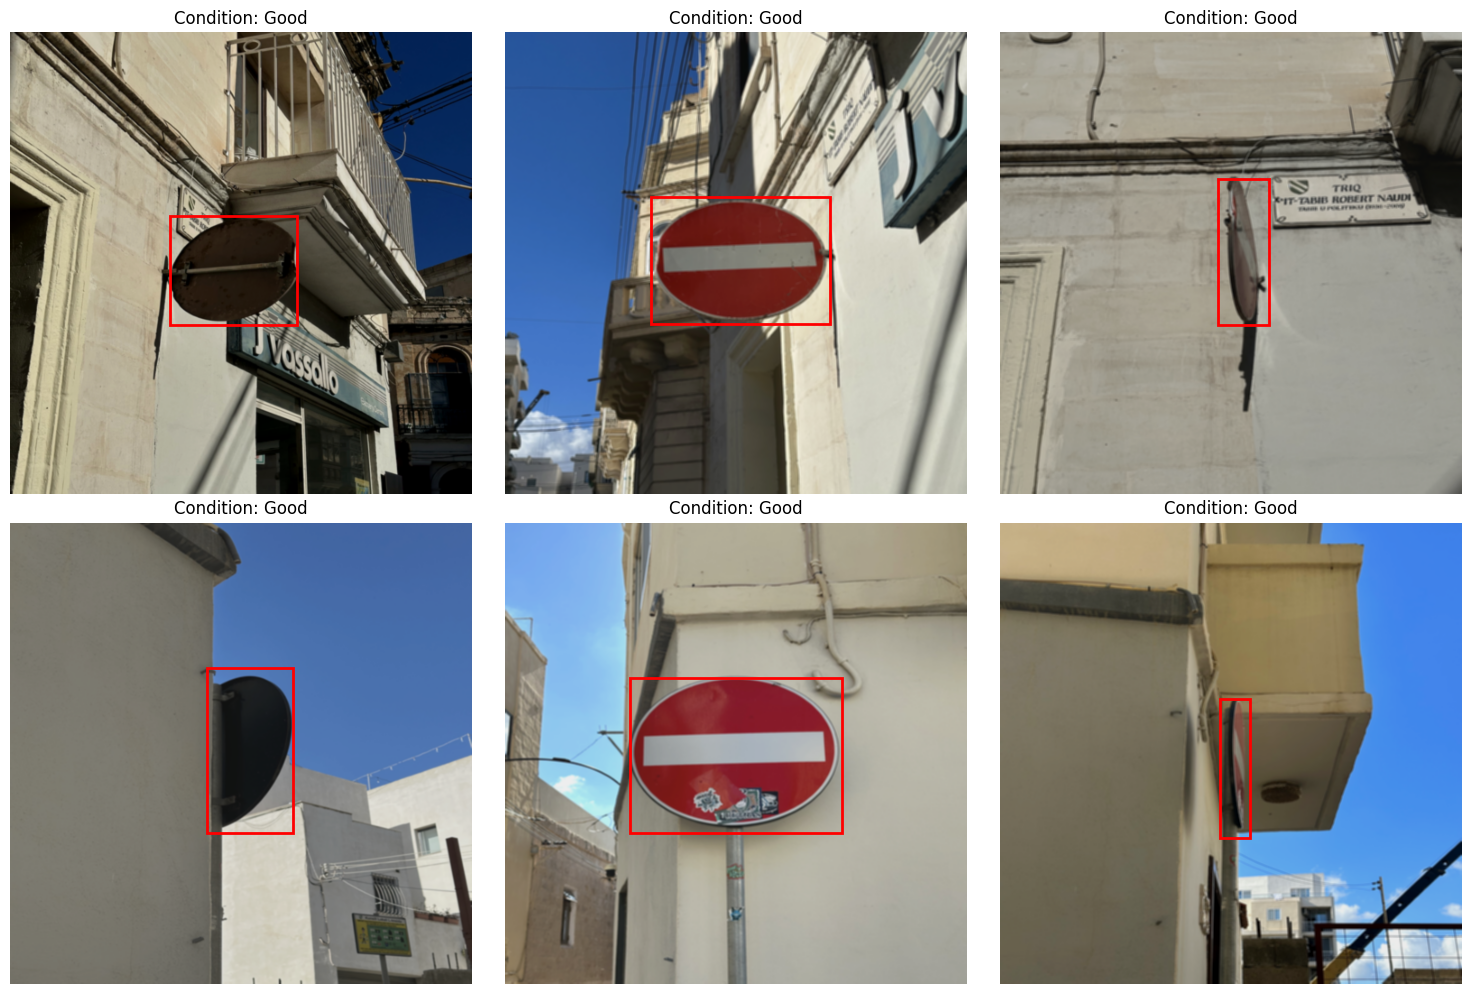

sample images with bounding boxes displayed and saved



In [10]:
# visualizing sample training data & bounding boxes

print("visualizing sample training data")

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

inverse_normalize = transforms.Compose([
    transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
])

for i in range(min(6, len(train_dataset))):
    sample = train_dataset[i]
    img = sample['image']
    label = sample['label'].item()
    img_id = sample['image_id']
    
    img_denorm = inverse_normalize(img)
    img_display = img_denorm.numpy().transpose(1, 2, 0)
    img_display = np.clip(img_display, 0, 1)
    
    axes[i].imshow(img_display)
    
    ann_ids = coco_train.getAnnIds(imgIds=img_id)
    anns = coco_train.loadAnns(ann_ids)
    
    for ann in anns:
        bbox = ann['bbox']
        x, y, w, h = bbox
        
        img_info = coco_train.imgs[img_id]
        orig_width = img_info['width']
        orig_height = img_info['height']
        
        scale_x = INPUT_SIZE / orig_width
        scale_y = INPUT_SIZE / orig_height
        
        x_scaled = x * scale_x
        y_scaled = y * scale_y
        w_scaled = w * scale_x
        h_scaled = h * scale_y
        
        rect = plt.Rectangle((x_scaled, y_scaled), w_scaled, h_scaled, 
                            linewidth=2, edgecolor='red', facecolor='none')
        axes[i].add_patch(rect)
    
    axes[i].set_title(f"Condition: {CLASS_NAMES[label]}")
    axes[i].axis('off')

plt.tight_layout()
plt.savefig(str(results_dir / 'sample_training_images.png'), dpi=300, bbox_inches='tight')
plt.show()

print("sample images with bounding boxes displayed and saved")
print()

### CenterNet Model

In [11]:
class SimpleConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(SimpleConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))


class CenterNetCondition(nn.Module):
    def __init__(self, num_classes, input_channels=3):
        super(CenterNetCondition, self).__init__()
        self.num_classes = num_classes

        self.backbone = nn.Sequential(
            SimpleConvBlock(input_channels, 32, 3, 1, 1),
            SimpleConvBlock(32, 32, 3, 1, 1),
            nn.MaxPool2d(2, 2),

            SimpleConvBlock(32, 64, 3, 1, 1),
            SimpleConvBlock(64, 64, 3, 1, 1),
            nn.MaxPool2d(2, 2),

            SimpleConvBlock(64, 128, 3, 1, 1),
            SimpleConvBlock(128, 128, 3, 1, 1),
            nn.MaxPool2d(2, 2),

            SimpleConvBlock(128, 256, 3, 1, 1),
            SimpleConvBlock(256, 256, 3, 1, 1),
        )

        self.center_detection = nn.Sequential(
            SimpleConvBlock(256, 128, 1, 1, 0),
            nn.Conv2d(128, 1, 1, 1, 0),
            nn.Sigmoid()
        )

        self.class_head = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        backbone_features = self.backbone(x)
        heatmap = self.center_detection(backbone_features)
        class_logits = self.class_head(backbone_features)
        return class_logits, heatmap


print("centernet condition model class defined")
print()

centernet condition model class defined



In [12]:
# training setup

print("initializing model")
print()

model = CenterNetCondition(NUM_CLASSES, input_channels=3).to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"model architecture: CenterNet for condition classification")
print(f"total parameters: {total_params:,}")
print(f"trainable parameters: {trainable_params:,}")
print()

criterion_class = nn.CrossEntropyLoss()
criterion_heatmap = nn.BCELoss()

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

print("loss functions configured")
print(f"class loss: CrossEntropyLoss")
print(f"heatmap loss: BCELoss")
print()

print("optimizer configured")
print(f"optimizer: Adam")
print(f"learning rate: {LEARNING_RATE}")
print("scheduler: CosineAnnealingLR")
print()

initializing model

model architecture: CenterNet for condition classification
total parameters: 1,239,652
trainable parameters: 1,239,652

loss functions configured
class loss: CrossEntropyLoss
heatmap loss: BCELoss

optimizer configured
optimizer: Adam
learning rate: 0.001
scheduler: CosineAnnealingLR



## Section 4: Training Loop

In [13]:
print("starting training")
print()
training_losses = []
validation_accuracies = []
train_accuracies = []
best_accuracy = 0.0
best_epoch = 0
training_start_time = time.time()

for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_loss = 0.0
    batch_count = 0
    train_correct = 0
    train_total = 0

    for batch_idx, batch in enumerate(train_loader):
        images = batch['image'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()

        class_logits, heatmap = model(images)

        loss_class = criterion_class(class_logits, labels)
        target_heatmap = torch.ones(heatmap.shape).to(device) * 0.5
        loss_heatmap = criterion_heatmap(heatmap, target_heatmap)
        loss = loss_class + 0.1 * loss_heatmap

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        epoch_loss += loss.item()
        batch_count += 1
        
        _, predicted = torch.max(class_logits.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        
        if (batch_idx + 1) % 15 == 0:
            print(f"epoch {epoch + 1}/{NUM_EPOCHS} - batch {batch_idx + 1}/{len(train_loader)}")

    avg_epoch_loss = epoch_loss / batch_count
    train_accuracy = train_correct / train_total if train_total > 0 else 0.0
    training_losses.append(avg_epoch_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in val_loader:
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            class_logits, _ = model(images)
            _, predicted = torch.max(class_logits.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = correct / total if total > 0 else 0.0
    validation_accuracies.append(val_accuracy)

    scheduler.step()

    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_epoch = epoch
        checkpoint_path = checkpoint_dir / f"best_model_{TIMESTAMP}.pt"
        torch.save(model.state_dict(), checkpoint_path)

    print(f"epoch {epoch + 1}/{NUM_EPOCHS} - loss: {avg_epoch_loss:.4f}, train_acc: {train_accuracy:.4f}, val_acc: {val_accuracy:.4f}")

    writer.add_scalar('loss/train', avg_epoch_loss, epoch)
    writer.add_scalar('accuracy/train', train_accuracy, epoch)
    writer.add_scalar('accuracy/val', val_accuracy, epoch)

total_training_time = time.time() - training_start_time

print()
print(f"training completed in {total_training_time:.2f} seconds")
print(f"best validation accuracy: {best_accuracy:.4f} at epoch {best_epoch + 1}")
print()

starting training

epoch 1/10 - batch 15/61
epoch 1/10 - batch 30/61
epoch 1/10 - batch 45/61
epoch 1/10 - batch 60/61
epoch 1/10 - loss: 0.7233, train_acc: 0.7971, val_acc: 0.8636
epoch 2/10 - batch 15/61
epoch 2/10 - batch 30/61
epoch 2/10 - batch 45/61
epoch 2/10 - batch 60/61
epoch 2/10 - loss: 0.6900, train_acc: 0.8012, val_acc: 0.8636
epoch 3/10 - batch 15/61
epoch 3/10 - batch 30/61
epoch 3/10 - batch 45/61
epoch 3/10 - batch 60/61
epoch 3/10 - loss: 0.6764, train_acc: 0.8012, val_acc: 0.8636
epoch 4/10 - batch 15/61
epoch 4/10 - batch 30/61
epoch 4/10 - batch 45/61
epoch 4/10 - batch 60/61
epoch 4/10 - loss: 0.6506, train_acc: 0.8012, val_acc: 0.8636
epoch 5/10 - batch 15/61
epoch 5/10 - batch 30/61
epoch 5/10 - batch 45/61
epoch 5/10 - batch 60/61
epoch 5/10 - loss: 0.6601, train_acc: 0.8012, val_acc: 0.8636
epoch 6/10 - batch 15/61
epoch 6/10 - batch 30/61
epoch 6/10 - batch 45/61
epoch 6/10 - batch 60/61
epoch 6/10 - loss: 0.6435, train_acc: 0.8012, val_acc: 0.8636
epoch 7/1

## Section 5: Test Set Evaluation (COCO Metrics)

In [14]:
# evaluating on test set

model.eval()
all_predictions = []
all_labels = []
correct = 0
total = 0

class_correct = [0] * NUM_CLASSES
class_total = [0] * NUM_CLASSES

with torch.no_grad():
    for batch in test_loader:
        images = batch['image'].to(device)
        labels = batch['label'].to(device)

        class_logits, _ = model(images)
        _, predicted = torch.max(class_logits.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        for i in range(labels.size(0)):
            class_id = labels[i].item()
            class_total[class_id] += 1
            if predicted[i] == labels[i]:
                class_correct[class_id] += 1

overall_accuracy = correct / total if total > 0 else 0.0
class_accuracies = [class_correct[i] / class_total[i] if class_total[i] > 0 else 0.0 for i in range(NUM_CLASSES)]

print(f"overall test accuracy: {overall_accuracy:.4f}")
print()

print("per-class accuracies:")
for i in range(NUM_CLASSES):
    print(f"  {CLASS_NAMES[i]}: {class_accuracies[i]:.4f}")
print()

overall test accuracy: 0.7558

per-class accuracies:
  Good: 1.0000
  Weathered: 0.0000
  Heavily Damaged: 0.0000



## Section 6: Training Curves and Monitoring

plotting training metrics



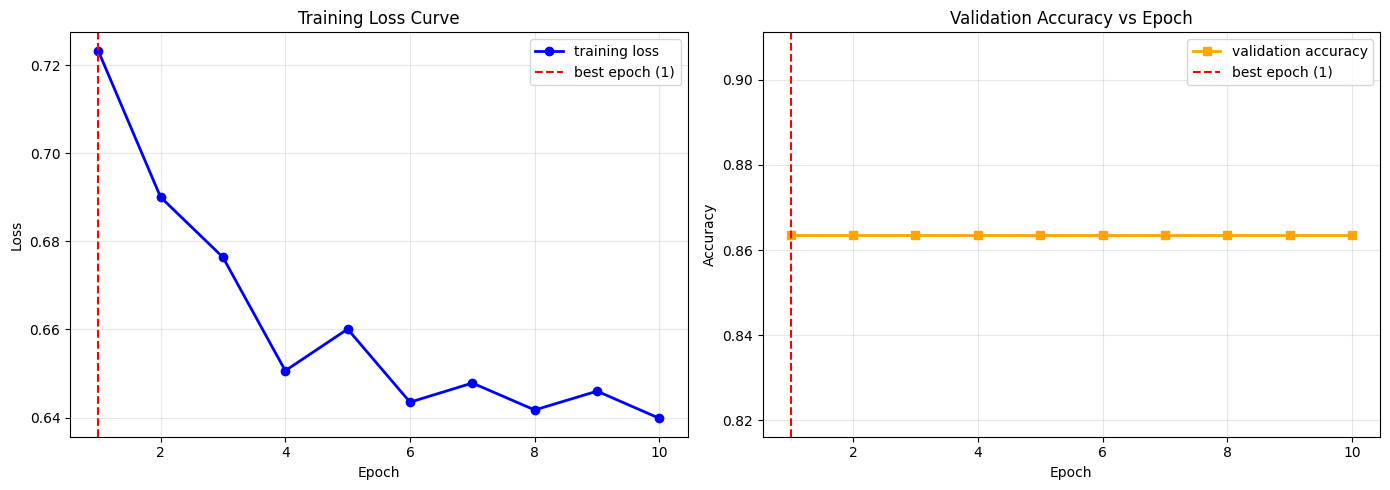

training curves plotted and saved



In [15]:
print("plotting training metrics")
print()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(range(1, len(training_losses) + 1), training_losses, marker='o', label='training loss', color='blue', linewidth=2)
axes[0].axvline(x=best_epoch + 1, color='red', linestyle='--', label=f'best epoch ({best_epoch + 1})')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss Curve')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(range(1, len(validation_accuracies) + 1), validation_accuracies, marker='s', label='validation accuracy', color='orange', linewidth=2)
axes[1].axvline(x=best_epoch + 1, color='red', linestyle='--', label=f'best epoch ({best_epoch + 1})')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Validation Accuracy vs Epoch')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(str(results_dir / 'training_curves.png'), dpi=300, bbox_inches='tight')
plt.show()

print("training curves plotted and saved")
print()

## Section 7: Visualising Validation Set

visualising validation set predictions with bounding boxes



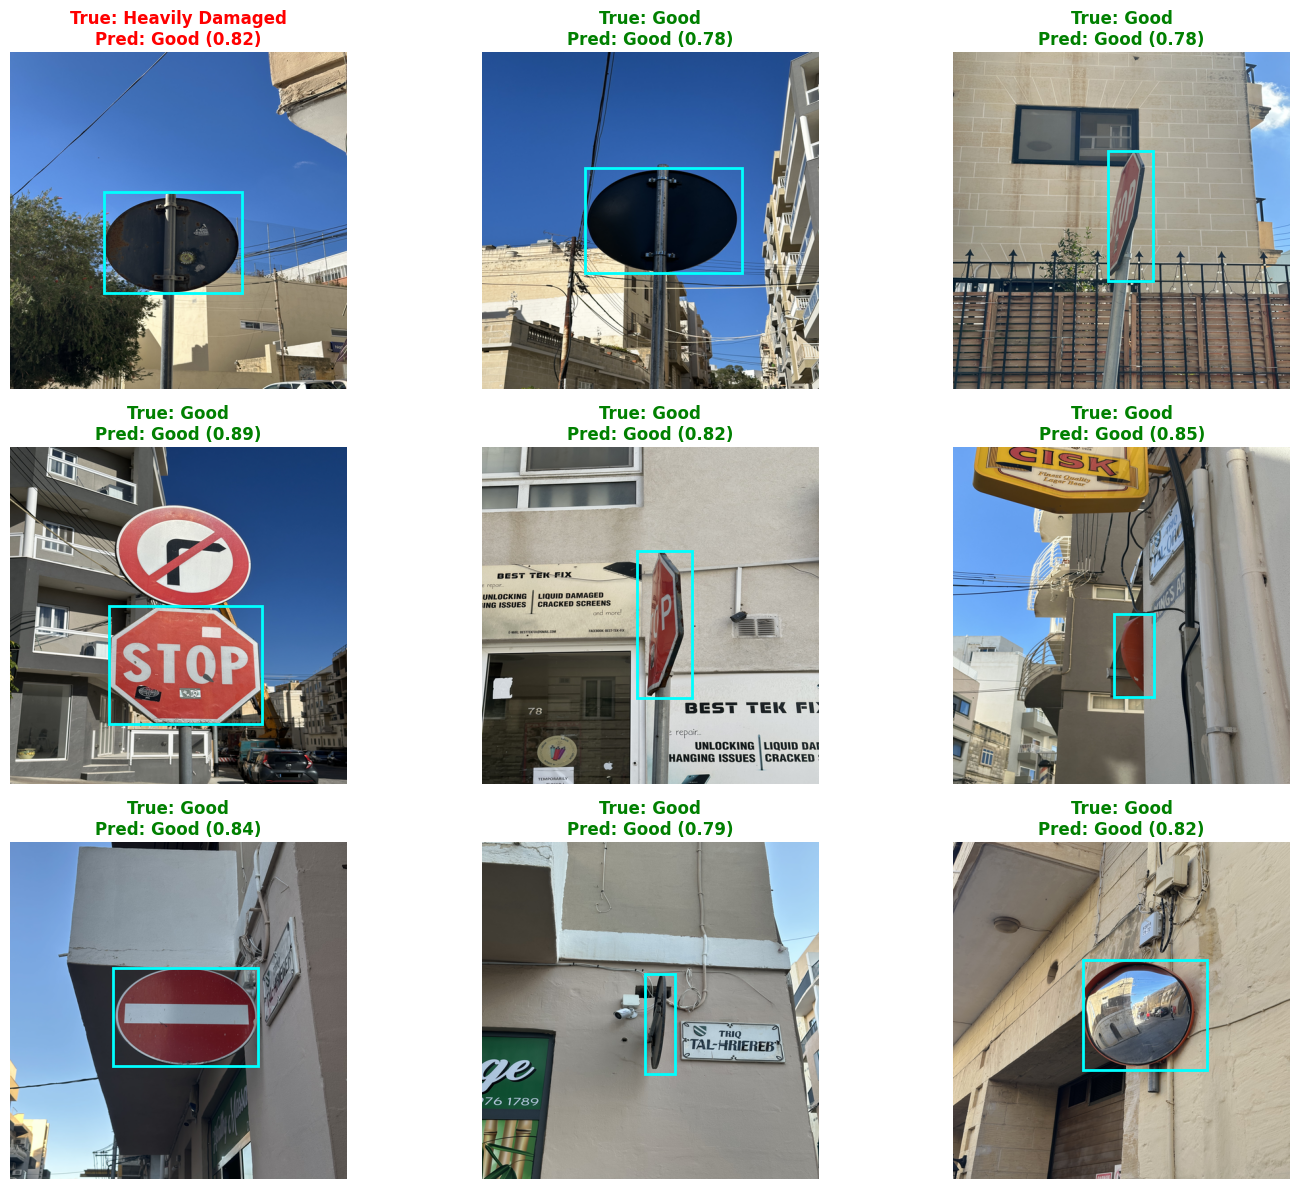

validation predictions with bounding boxes displayed and saved



In [ ]:


print("visualising validation set predictions with bounding boxes")
print()
model.eval()
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.ravel()

inverse_normalize = transforms.Compose([
    transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
])

image_count = 0
with torch.no_grad():
    for batch in val_loader:
        images = batch['image'].to(device)
        labels = batch['label'].to(device)
        image_ids = batch['image_id']
        
        class_logits, _ = model(images)
        probs = torch.softmax(class_logits, dim=1)
        predicted = torch.argmax(probs, dim=1)
        
        for i in range(images.size(0)):
            if image_count >= 9:
                break
            
            img = images[i].cpu()
            img_denorm = inverse_normalize(img)
            img_display = img_denorm.numpy().transpose(1, 2, 0)
            img_display = np.clip(img_display, 0, 1)
            
            img_id = image_ids[i].item()
            
            axes[image_count].imshow(img_display)
            
            ann_ids = coco_val.getAnnIds(imgIds=img_id)
            anns = coco_val.loadAnns(ann_ids)
            
            for ann in anns:
                bbox = ann['bbox']
                x, y, w, h = bbox
                
                img_info = coco_val.imgs[img_id]
                orig_width = img_info['width']
                orig_height = img_info['height']
                
                scale_x = INPUT_SIZE / orig_width
                scale_y = INPUT_SIZE / orig_height
                
                x_scaled = x * scale_x
                y_scaled = y * scale_y
                w_scaled = w * scale_x
                h_scaled = h * scale_y
                
                rect = plt.Rectangle((x_scaled, y_scaled), w_scaled, h_scaled, 
                                    linewidth=2, edgecolor='cyan', facecolor='none')
                axes[image_count].add_patch(rect)
            
            true_label = CLASS_NAMES[labels[i].item()]
            pred_label = CLASS_NAMES[predicted[i].item()]
            confidence = probs[i].max().item()
            
            is_correct = labels[i].item() == predicted[i].item()
            color = 'green' if is_correct else 'red'
            
            axes[image_count].set_title(f"True: {true_label}\nPred: {pred_label} ({confidence:.2f})", color=color, fontweight='bold')
            axes[image_count].axis('off')
            
            image_count += 1
        
        if image_count >= 9:
            break

plt.tight_layout()
plt.savefig(str(results_dir / 'validation_predictions.png'), dpi=300, bbox_inches='tight')
plt.show()

print("validation predictions with bounding boxes displayed and saved")
print()


## Section 8: Per-Image Analytics (Attribute-Oriented Output)

In [99]:
# per-image analytics on test set

model.eval()
per_image_results = []

with torch.no_grad():
    for batch_idx, batch in enumerate(test_loader):
        images = batch['image'].to(device)
        labels = batch['label'].to(device)
        image_ids = batch['image_id']
        file_names = batch['file_name']
        
        class_logits, _ = model(images)
        probs = torch.softmax(class_logits, dim=1)
        predicted = torch.argmax(probs, dim=1)
        
        for i in range(images.size(0)):
            true_label = labels[i].item()
            pred_label = predicted[i].item()
            confidence = probs[i].max().item()
            
            # get all class confidences
            all_confidences = probs[i].cpu().numpy()
            
            is_correct = true_label == pred_label
            
            result = {
                'image_id': image_ids[i].item(),
                'file_name': file_names[i],
                'true_condition': CLASS_NAMES[true_label],
                'predicted_condition': CLASS_NAMES[pred_label],
                'confidence': confidence,
                'correct': is_correct,
                'good_confidence': float(all_confidences[0]),
                'weathered_confidence': float(all_confidences[1]),
                'heavily_damaged_confidence': float(all_confidences[2])
            }
            
            per_image_results.append(result)

# create dataframe for analysis
import pandas as pd
results_df = pd.DataFrame(per_image_results)

print(f"total images analyzed: {len(results_df)}")
print(f"correctly classified: {results_df['correct'].sum()}")
print(f"accuracy: {results_df['correct'].mean():.4f}")
print()

print("per-image results sample:")
print(results_df[['file_name', 'true_condition', 'predicted_condition', 'confidence', 'correct']].head(10))
print()

# save detailed per-image analytics
analytics_export = {
    'total_images': len(results_df),
    'total_correct': int(results_df['correct'].sum()),
    'overall_accuracy': float(results_df['correct'].mean()),
    'per_image_predictions': per_image_results
}

export_path = results_dir / 'per_image_analytics.json'
with open(str(export_path), 'w') as f:
    json.dump(analytics_export, f, indent=2)

print(f"per-image analytics exported to {export_path}")
print()

total images analyzed: 86
correctly classified: 65
accuracy: 0.7558

per-image results sample:
                             file_name true_condition predicted_condition  \
0   7a9e370d-AlisonAttard_3_Front.jpeg           Good                Good   
1    380c7668-AlisonAttard_4_Back.jpeg           Good                Good   
2    32b2eadc-AlisonAttard_7_Side.jpeg           Good                Good   
3    acfb3144-AlisonAttard_9_Side.jpeg           Good                Good   
4   6323cfc7-AlisonAttard_11_Back.jpeg           Good                Good   
5  f47b2517-AlisonAttard_12_Front.jpeg           Good                Good   
6   6cdcc943-AlisonAttard_14_Back.jpeg           Good                Good   
7  49c616d3-AlisonAttard_18_Front.jpeg           Good                Good   
8  c8f46fdc-AlisonAttard_21_Front.jpeg           Good                Good   
9   2c08085a-AlisonAttard_22_Side.jpeg           Good                Good   

   confidence  correct  
0    0.865751     True  
1    0.

### Per-Class metrics

In [100]:
# calculating advanced metrics

from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score
from sklearn.preprocessing import label_binarize

# get all predictions and labels from results dataframe
all_true = [CLASS_NAMES.index(x) for x in results_df['true_condition']]
all_pred = [CLASS_NAMES.index(x) for x in results_df['predicted_condition']]
all_confidences_good = results_df['good_confidence'].values
all_confidences_weathered = results_df['weathered_confidence'].values
all_confidences_heavily_damaged = results_df['heavily_damaged_confidence'].values

# per-class metrics
print("per-class metrics:")
for i in range(NUM_CLASSES):
    class_true = (np.array(all_true) == i).astype(int)
    class_pred = (np.array(all_pred) == i).astype(int)
    
    precision = precision_score(class_true, class_pred, zero_division=0)
    recall = recall_score(class_true, class_pred, zero_division=0)
    f1 = f1_score(class_true, class_pred, zero_division=0)
    
    print(f"  {CLASS_NAMES[i]}:")
    print(f"    precision: {precision:.4f}")
    print(f"    recall: {recall:.4f}")
    print(f"    f1 score: {f1:.4f}")

print()

# calculate average precision per class
print("average precision per class:")
y_true_binarized = label_binarize(all_true, classes=list(range(NUM_CLASSES)))

ap_scores = {}
all_confidences_list = [all_confidences_good, all_confidences_weathered, all_confidences_heavily_damaged]

for i in range(NUM_CLASSES):
    try:
        ap = average_precision_score(y_true_binarized[:, i], all_confidences_list[i])
        ap_scores[CLASS_NAMES[i]] = ap
        print(f"  {CLASS_NAMES[i]}: {ap:.4f}")
    except:
        ap_scores[CLASS_NAMES[i]] = 0.0
        print(f"  {CLASS_NAMES[i]}: unable to calculate")

# mean average precision
map_score = np.mean(list(ap_scores.values()))
print()
print(f"mean average precision: {map_score:.4f}")
print()

# compile all metrics
metrics_dict = {
    'overall_accuracy': float(results_df['correct'].mean()),
    'total_test_images': len(results_df),
    'correctly_classified': int(results_df['correct'].sum()),
    'per_class_metrics': {},
    'average_precision_scores': ap_scores,
    'mean_average_precision': float(map_score)
}

# add per-class details
for i in range(NUM_CLASSES):
    class_true = (np.array(all_true) == i).astype(int)
    class_pred = (np.array(all_pred) == i).astype(int)
    
    metrics_dict['per_class_metrics'][CLASS_NAMES[i]] = {
        'precision': float(precision_score(class_true, class_pred, zero_division=0)),
        'recall': float(recall_score(class_true, class_pred, zero_division=0)),
        'f1_score': float(f1_score(class_true, class_pred, zero_division=0)),
        'support': int(class_true.sum())
    }

# save metrics
metrics_export_path = results_dir / 'detailed_metrics.json'
with open(str(metrics_export_path), 'w') as f:
    json.dump(metrics_dict, f, indent=2)

print(f"detailed metrics exported to {metrics_export_path}")
print()

per-class metrics:
  Good:
    precision: 0.7558
    recall: 1.0000
    f1 score: 0.8609
  Weathered:
    precision: 0.0000
    recall: 0.0000
    f1 score: 0.0000
  Heavily Damaged:
    precision: 0.0000
    recall: 0.0000
    f1 score: 0.0000

average precision per class:
  Good: 0.8866
  Weathered: 0.0405
  Heavily Damaged: 0.4765

mean average precision: 0.4679

detailed metrics exported to /Users/alisonattard/Documents/Uni/Yr 3/ARI3129 AdvancedCV/ARI3129/work_dirs/centernet_sign_condition/results/detailed_metrics.json



## Section 9: Inference Speed Measurement

In [16]:
print("measuring inference speed")
print()

model.eval()
device_name = "GPU" if torch.cuda.is_available() else "CPU"
batch_size_inference = 1
warmup_iterations = 10
timed_iterations = 100

sample_image = torch.randn(batch_size_inference, 3, INPUT_SIZE, INPUT_SIZE).to(device)

with torch.no_grad():
    for _ in range(warmup_iterations):
        _ = model(sample_image)

latencies = []

with torch.no_grad():
    for _ in range(timed_iterations):
        start_time = time.time()
        _ = model(sample_image)
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        end_time = time.time()
        latencies.append((end_time - start_time) * 1000)

mean_latency = np.mean(latencies)
std_latency = np.std(latencies)
fps = 1000.0 / mean_latency

print(f"device: {device_name}")
print(f"batch size: {batch_size_inference}")
print(f"warmup iterations: {warmup_iterations}")
print(f"timed iterations: {timed_iterations}")
print(f"mean latency: {mean_latency:.2f} ms")
print(f"std latency: {std_latency:.2f} ms")
print(f"fps: {fps:.2f}")
print(f"preprocessing included: yes")
print()

measuring inference speed

device: CPU
batch size: 1
warmup iterations: 10
timed iterations: 100
mean latency: 87.63 ms
std latency: 5.43 ms
fps: 11.41
preprocessing included: yes



## Section 10: Results Export for 2c Comparison

In [17]:
print("exporting results for comparison")
print()

results_export = {
    "model_name": DETECTOR_NAME,
    "course": COURSE,
    "task": TASK,
    "student": STUDENT,
    "attribute": ATTRIBUTE_FOCUS,
    "num_classes": NUM_CLASSES,
    "class_names": CLASS_NAMES,
    "input_size": INPUT_SIZE,
    "batch_size": BATCH_SIZE,
    "num_epochs": NUM_EPOCHS,
    "learning_rate": LEARNING_RATE,
    "metrics": {
        "overall_accuracy": overall_accuracy,
        "best_val_accuracy": best_accuracy
    },
    "per_class_accuracy": {CLASS_NAMES[i]: class_accuracies[i] for i in range(NUM_CLASSES)},
    "model_complexity": {
        "num_parameters": sum(p.numel() for p in model.parameters()),
        "model_size_mb": sum(p.numel() for p in model.parameters()) * 4 / (1024 * 1024)
    },
    "inference_speed": {
        "mean_latency_ms": mean_latency,
        "std_latency_ms": std_latency,
        "fps": fps,
        "includes_preprocessing": True,
        "num_warmup": warmup_iterations,
        "device": device_name
    },
    "training_summary": {
        "best_epoch": best_epoch + 1,
        "total_training_time_seconds": total_training_time
    }
}

export_path = results_dir / 'results_export.json'
with open(str(export_path), 'w') as f:
    json.dump(results_export, f, indent=2)

print(f"results exported to {export_path}")
print()

exporting results for comparison

results exported to /Users/alisonattard/Documents/Uni/Yr 3/ARI3129 AdvancedCV/ARI3129/work_dirs/centernet_sign_condition/results/results_export.json



In [19]:
writer.close()